---

<center>
<h1>Pronóstico de la productividad forrajera y balance</h1>
<h1>hídrico en la región de los pastizales del Río de la Plata</h1>
</center>

---


<br>
<br>
<ul>
    <li>Bartol, Tomás Augusto</li>
    <li>Peiretti, Pablo </li>
    <li>Sánchez, Milagros Verónica </li>
</li>
</ul>


<br>
<h2>Abstract</h2>

This notebook was created with the purpose of performing data normalization on the information provided by the photodetection department of the Buenos Aires University.

In [1]:
### Load the imports ### 
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

### The following lines adjust the granularity of reporting. ### 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [2]:
### Define program constants ### 
DATABASE_PATH = "Database\database.csv"
SEQUENCE_LEN = 26 #26 points equals 26*15 days equals a year aprox.

In [3]:
# Load the dataset
aux_df = pd.read_csv(DATABASE_PATH)
scale_factor = 1000.0
# Shuffle the examples
#train_df = train_df.reindex(np.random.permutation(train_df.index))
#print(aux_df[['date']])

In [4]:
def convert_to_timestamp(date_str):

    if(isinstance(aux_df['date'][0], np.int64)):
      return False #NOT ROBUST, FAILS IF RUN TWICE ON THE SAME DF

    date_obj = datetime.strptime(date_str, "%m/%d/%Y")
    return int(date_obj.timestamp())# * 1000) Optional multiplication by 1000 to turn into miliseconds.


aux_df['date'] = aux_df['date'].apply(convert_to_timestamp)

In [5]:
#Check if dates are correctly turned into a timsetamp format
date = datetime.fromtimestamp(aux_df['date'][0])
year = date.year
month = date.month
day = date.day

In [6]:
#divide the dataframe into three sections (train, test, validation) with roughly a 70-20-10 distribution
#The samples are divided secuentially to improve the RNN performance

train_df, test_df = train_test_split(aux_df, test_size=0.2, shuffle=False)  # 80% to training df and 20% to testing df
train_df, val_df = train_test_split(train_df, test_size=0.1, shuffle=False)  # Of the 80%, 90% goes to training and 10% to validation

# To make each df legth divisible by the batches in the model building section
train_df = train_df[:-(len(train_df) % SEQUENCE_LEN)]
val_df = val_df[:-(len(val_df) % SEQUENCE_LEN)]
test_df = test_df[:-(len(test_df) % SEQUENCE_LEN)]


DATA NORMALIZATION INFO

https://medium.com/@spinjosovsky/normalize-data-before-or-after-split-of-training-and-testing-data-7b8005f81e26
https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well

In [7]:
# Normalization of every dataframe. The chosen normalization uses mean and standard deviation
# Every Dataframe must be normalized by the same values, hence the train df mean and deviation are saved
train_mean = train_df.mean()
train_std = train_df.std()


def normalize_data(data, mean, std):
    return (data - mean) / std

#The id field shouldn't be normalized yet is not used in the model
train_normalized = normalize_data(train_df, train_mean, train_std)
val_normalized = normalize_data(val_df, train_mean, train_std)
test_normalized = normalize_data(test_df, train_mean, train_std)

In [8]:
# Keras Input tensors of float values.
#The prediction is going to use one value for lat, long, precipitation, temperature (the ones on the date desired to estimate)
#and the SEQUENCE_LEN previous values of ppna
inputs = {
    'date':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='date'),
    'latitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='latitude'),
    'longitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='longitude'),
    'ppna':
        tf.keras.layers.Input(shape=(SEQUENCE_LEN, 1), dtype=tf.float32,
                             name='ppna'),
    'precipitation':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='precipitation'),
    'temperature':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='temperature')
}

In [9]:
# Define the model for the NN
# LSTM layer with 64 nodes processing the ppna -- the only parameter that takes info from the past
lstm_layer = tf.keras.layers.LSTM(64)(inputs['ppna'])

# Concatenate the inputs and LSTM output to provide the model tools to learn the patterns
concatenated_features = tf.keras.layers.concatenate([inputs['date'], inputs['latitude'], inputs['longitude'], inputs['precipitation'], inputs['temperature'], lstm_layer])

# Output Layer, with just one output (Estimated PPNA) that receives the concatenated features
output = tf.keras.layers.Dense(1, name='ppna_output')(concatenated_features)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ppna (InputLayer)           [(None, 26, 1)]              0         []                            
                                                                                                  
 date (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 latitude (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 longitude (InputLayer)      [(None, 1)]                  0         []                            
                                                                                              

In [10]:
#Model training

#Define the training parameters
epochs = 5  
batch_size = 64 

#Define the features and labels for each section of the process.
#The label is the ppna (what we want to predict)
#The features are the values used to predict said label (previous ppna, precipitations, temperature, lat, long, date)
train_labels = train_normalized['ppna'] 
train_features = {
        'date': train_normalized['date'],
        'latitude': train_normalized['latitude'],
        'longitude': train_normalized['longitude'],
        'ppna': train_normalized['ppna'],
        'precipitation': train_normalized['ppt'],
        'temperature': train_normalized['temp']
}

val_labels = val_normalized['ppna'] 
val_features = {
         'date': val_normalized['date'],
         'latitude': val_normalized['latitude'],
         'longitude': val_normalized['longitude'],
         'ppna': val_normalized['ppna'],
         'precipitation': val_normalized['ppt'],
         'temperature': val_normalized['temp']
}

test_labels = test_normalized['ppna']
test_features = {
    'date': test_normalized['date'],
    'latitude': test_normalized['latitude'],
    'longitude': test_normalized['longitude'],
    'ppna': test_normalized['ppna'],
    'precipitation': test_normalized['ppt'],
    'temperature': test_normalized['temp']
}

#Train the model with the previously defined parameters and data
history = model.fit(
    train_features, 
    train_labels.values, 
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_features, val_labels.values)  
)

# Evaluate the model
test_loss = model.evaluate(test_features, test_labels)  

print("Pérdida en el conjunto de prueba:", test_loss)

Epoch 1/5
7763/7763 [==============================] - 53s 7ms/step - loss: 0.0072 - mae: 0.0193 - accuracy: 0.0000e+00 - val_loss: 2.1059e-06 - val_mae: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2/5
7763/7763 [==============================] - 48s 6ms/step - loss: 2.8434e-06 - mae: 0.0010 - accuracy: 0.0000e+00 - val_loss: 5.2443e-06 - val_mae: 0.0019 - val_accuracy: 0.0000e+00
Epoch 3/5
7763/7763 [==============================] - 38s 5ms/step - loss: 2.1295e-06 - mae: 8.5325e-04 - accuracy: 0.0000e+00 - val_loss: 7.3837e-07 - val_mae: 6.3052e-04 - val_accuracy: 0.0000e+00
Epoch 4/5
7763/7763 [==============================] - 33s 4ms/step - loss: 1.7705e-06 - mae: 7.5872e-04 - accuracy: 0.0000e+00 - val_loss: 5.6348e-07 - val_mae: 5.5914e-04 - val_accuracy: 0.0000e+00
Epoch 5/5
4312/4312 [==============================] - 12s 3ms/step - loss: 2.6778e-06 - mae: 0.0012 - accuracy: 0.0000e+00
Pérdida en el conjunto de prueba: [2.6778436676977435e-06, 0.0011911154724657536, 0.0]


In [11]:
test_loss = model.evaluate(test_features, test_labels.values)  

4312/4312 [==============================] - 13s 3ms/step - loss: 2.6778e-06 - mae: 0.0012 - accuracy: 0.0000e+00


In [12]:
train_labels

0         1.2
1         0.9
2         1.4
3         0.6
4         0.3
         ... 
496777    2.0
496778    1.7
496779    1.1
496780    1.5
496781   -0.1
Name: ppna, Length: 496782, dtype: float64

In [13]:
output= model.predict(test_features)

4312/4312 [==============================] - 13s 3ms/step


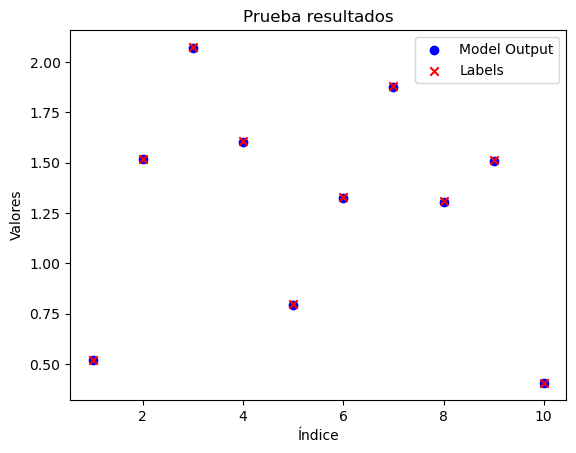

In [22]:
indice = np.arange(1, 11)
plt.scatter(indice, output[137972:137982], label='Model Output', color='blue', marker='o')
plt.scatter(indice, test_labels.values[137972:137982], label='Labels', color='red', marker='x')
# Agregar etiquetas al gráfico
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Prueba resultados')

# Agregar una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [15]:
output[0:10]

array([[ 0.8260949 ],
       [ 0.5497051 ],
       [ 0.17622578],
       [ 0.02948895],
       [-0.1902569 ],
       [-0.6320661 ],
       [-0.5799729 ],
       [-0.99580044],
       [-1.1996655 ],
       [-1.3894095 ]], dtype=float32)

In [16]:
print(test_labels.values[0:10])

[ 0.82817595  0.55131022  0.17709505  0.03009318 -0.18994747 -0.63195058
 -0.57984389 -0.9956881  -1.19978138 -1.39002985]
